In [1]:
import sqlite3
import numpy as np
import pandas as pd
import folium
import matplotlib.pylab as plt
from scipy.cluster.vq import kmeans2, whiten
import seaborn as sns; sns.set_theme(color_codes=True)
from sklearn.cluster import KMeans

from scripts import write_weather_data
from utils import weather

conn = sqlite3.connect(r'locations.db')
df_weather = pd.read_sql_query("SELECT Weather.id, min_temp, max_temp, mean_temp, City.city_id, timestamp, name, \
                               City.country_id, City.lat,City.lon, City.altitude \
                               FROM Weather JOIN City ON (Weather.city_id=City.city_id)", conn)
df_city = pd.read_sql_query("SELECT City.name, city_id, lat, lon, altitude, Country.name AS CountryName, Continent.name AS ContinentName from City \
                            JOIN Country ON (City.country_id=Country.id) \
                            JOIN Continent ON (Country.continent_id=Continent.id)"
                            , conn)


In [2]:
m = folium.Map(location=[20,0], tiles="OpenStreetMap", zoom_start=2)

In [3]:
continent_colors = {
    'Asia': 'red',
    'Africa': 'blue',
    'Oceania': 'orange',
    'Europe': 'pink',
    'North America': 'green',
    'South America': 'lightred'
}

In [4]:
for city in write_weather_data.city_list:
    target_city = df_city.get(df_city['name']== city)
    icon_color = continent_colors[target_city.ContinentName.iloc[0]]
    folium.Marker(location=[target_city['lat'], target_city['lon']],
                icon=folium.Icon(color=icon_color, icon="info-sign"),
                popup=target_city.name.iloc[0]).add_to(m)
    


In [5]:
m

In [6]:
df_mean_values_cities = df_weather.groupby('name').mean()
df_mean_values_cities.head()

,id,min_temp,max_temp,mean_temp,city_id,country_id,lat,lon,altitude
name,,,,,,,,,
Arizona City,840.5,2.581667,19.803333,11.192500,5551665.0,2.0,32.75589,-111.67096,99.0
Auckland,780.5,14.753333,23.481667,19.117500,2193733.0,19.0,-36.86667,174.76667,26.0
Bangkok,600.5,22.508333,31.746667,27.127500,1609350.0,47.0,13.75398,100.50144,2.0
Beijing,615.5,-10.148333,3.836667,-3.155833,1816670.0,69.0,39.90750,116.39723,63.0
Bogota,923.0,8.085000,19.666667,13.875833,3688689.0,100.0,4.60970,-74.08180,2620.0


<AxesSubplot:xlabel='name'>

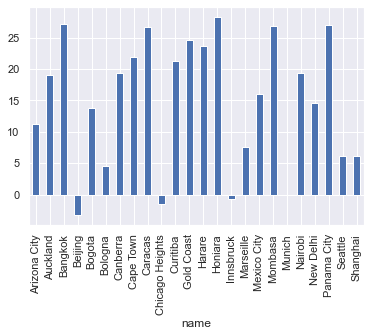

In [7]:
df_mean_values_cities['mean_temp'].plot.bar()

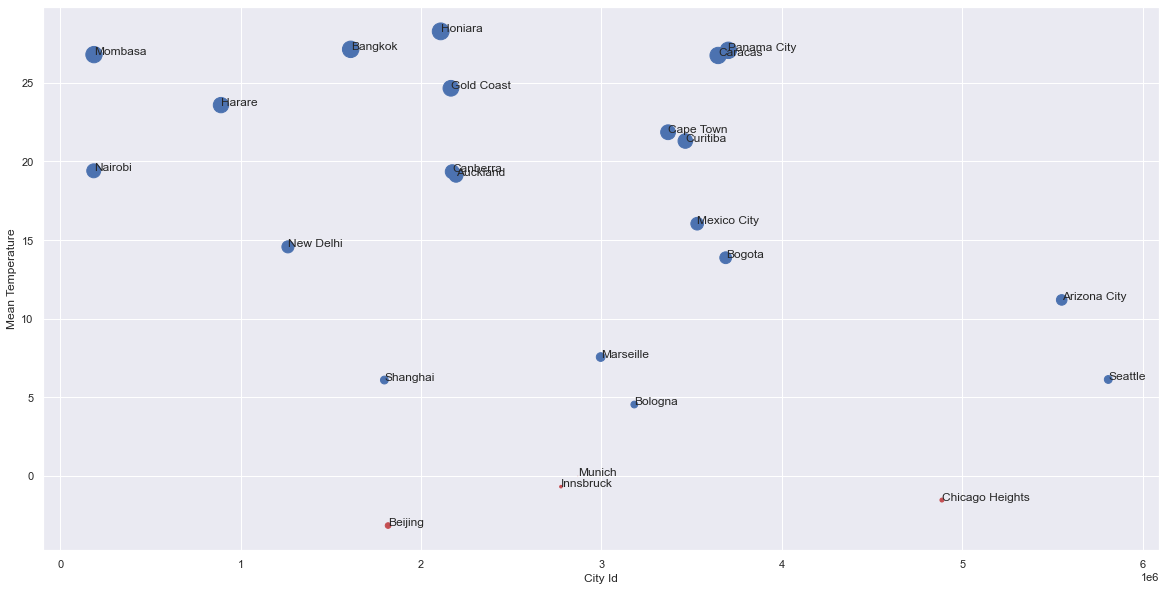

In [12]:
# Average value for the MEAN temp for each location.

city_name = df_city[['city_id', 'name']]
df_mean_values_cities.dropna()
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel('Mean Temperature')
ax.set_xlabel('City Id')
df_mean_values_cities_positive = df_mean_values_cities[df_mean_values_cities.mean_temp > 0]
df_mean_values_cities_negative = df_mean_values_cities[df_mean_values_cities.mean_temp < 0]
ax.scatter(df_mean_values_cities_positive.city_id,
           df_mean_values_cities_positive.mean_temp,
           color='b',
           s=df_mean_values_cities_positive['mean_temp']* 10)
ax.scatter(df_mean_values_cities_negative.city_id,
            df_mean_values_cities_negative.mean_temp, color='r', s=df_mean_values_cities_negative['mean_temp']*-10)

for key, row in df_mean_values_cities_positive.iterrows():
    _city_name = city_name.loc[city_name['city_id'] == row['city_id']]['name'].all()
    ax.annotate(_city_name, xy=(row['city_id'], row['mean_temp']))
    
for key, row in df_mean_values_cities_negative.iterrows():
    _city_name = city_name.loc[city_name['city_id'] == row['city_id']]['name'].all()
    ax.annotate(_city_name, xy=(row['city_id'], row['mean_temp']))
    
ax.autoscale()
plt.show()


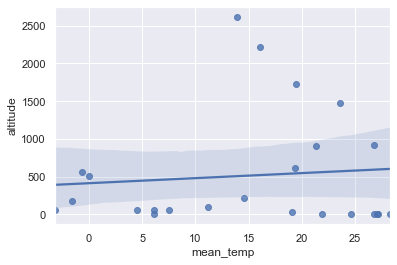

In [9]:
ax = sns.regplot(x="mean_temp",
                 y="altitude",
                 data=df_mean_values_cities[['mean_temp', 'altitude']],
                )

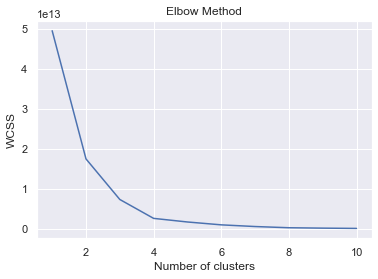

In [10]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_mean_values_cities)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

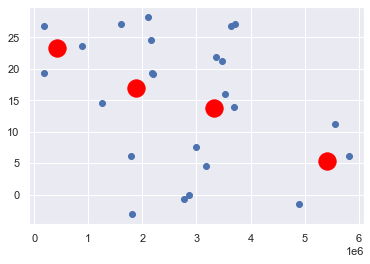

In [11]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df_mean_values_cities[['city_id', 'mean_temp']])
plt.scatter(df_mean_values_cities.city_id, df_mean_values_cities.mean_temp)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()